In [3]:
%load_ext autoreload
%autoreload 2

# Santander Customer Transaction Prediction

## General Information

The Kaggle competition site can be found [here](https://www.kaggle.com/c/santander-customer-transaction-prediction).

## Importing python packages

We will use the common SciPy stack, `numpy`, `pandas`, `scikit-learn`, etc.

In [88]:
from IPython.display import Markdown, display

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

## Configuration

Set some common `matplotlib` preferences:

In [95]:
%matplotlib inline
plt.style.use("ggplot")
mpl.rcParams["figure.figsize"] = (8, 8)

## Importing the dataset

Read the `.csv` files, but apply the columns of the large dataset to the small train dataset, as it does not include column headers.

In [60]:
train_large = pd.read_csv("data/train.csv")
test_large = pd.read_csv("data/test.csv")

test_small = pd.read_csv("data/test_small.csv")
train_small = pd.read_csv(
    "data/train_small.csv",
    names=train_large.columns,
    header=None,
    index_col=False,
)

# EDA

Let's start by checking if the small training set is a proper subset of the large training set.

In [10]:
assert len(train_large.merge(train_small)) == len(train_small)

Yes, it is. Therefore, if we conclude that the large dataset does not contain duplicates, null values, etc., the same conclusion should hold for the small training set. We will use this fact in order to draw conclusions for both datasets in a lot of cases.

## What data do we have?

What columns do we actually have?

In [18]:
train_large.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

And what datatypes are they?

In [19]:
train_large.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

The `ID_code` is probobaly an unique identifier for each row.

In [22]:
train_large.ID_code.is_unique

True

Yes, it is in fact an unique string, here are examples for both datasets.

In [25]:
train_large.ID_code[0:5], train_small.ID_code[0:5]

(0    train_0
 1    train_1
 2    train_2
 3    train_3
 4    train_4
 Name: ID_code, dtype: object, 0    train_1
 1    train_2
 2    train_4
 3    train_5
 4    train_6
 Name: ID_code, dtype: object)

The `target` column is probably our binary `0`/`1` classification label:

In [30]:
train_large.target.isin([0, 1]).all()

True

Yes, all the values of `target` are `0`/`1` encoded. The remaining columns are features named `var_0`, `var_1`, ..., `var_199`, all of them floating point values, 200 of them to be precise. Let's make sure that this is correct:

In [213]:
features = train_large.columns[2:]
assert len(features) == 200
assert (train_large.dtypes[2:] == "float64").all()

Yes, this is correct. One of the problems with this dataset is that the underlying source of these features are unknown, they are a completely black box. Attaining domain knowledge about these features will therefore be more difficult than if we had known the underlying meaning of these variables.

Before we take a look at the number of observations, it is first nice to look at how many missing values we have in order to make the correct conclusions regarding the "real" size of the dataset.

## Missing values

Let's find out if we have any missing values in the form of `NaN`s.

In [11]:
assert not train_large.isnull().values.any()
assert not test_large.isnull().values.any()
assert not test_small.isnull().values.any()

We have no null values whatsoever in any of the datasets, so we need not concern ourselfes with _missing_ values at the moment.
There is a chance that missing values are not indicated as `NaN`s in the dataset, however, but rather with a placeholder value within the `float64` domain. We will look out for such a possibility in the upcoming EDA to find out if this is the case.

## Size of datasets

Now let's look at how large the datasets are, starting by number of observations.

In [63]:
datasets = {
    "small training": train_small,
    "small test": test_small,
    "large training": train_large,
    "large test": test_large,
}
for name, dataset in datasets.items():
    display(Markdown(f"* The number of observations in the **{name} set** is: **{len(dataset)}**"))

* The number of observations in the **small training set** is: **70057**

* The number of observations in the **small test set** is: **70065**

* The number of observations in the **large training set** is: **200000**

* The number of observations in the **large test set** is: **200000**

We have a 50/50 split of train vs test data, the smaller dataset being 35% of the larger dataset.

## Check covariate vector uniqueness

Since `var_0`, ..., `var_199` are floating point values, it is unlikely that there are non-unique feature vectors in the dataset, but we should make sure anyway, just in case.

In [70]:
train_large.iloc[:, 2:].duplicated(subset=None, keep=False).any()

False

We have no **exact** duplicates, but remember that we could have extremely identical rows and this test would not capture this. We will come back to this issue.

## Check single covariate uniqueness

How unique are these floating point features when we look at one and one feature at a time?
Let's take a quick look:

In [145]:
unique_large_train = []
unique_small_train = []

for covariate in range(2, 202):
    unique_large_train.append(len(train_large.iloc[:, covariate].drop_duplicates())/len(train_large))
    unique_small_train.append(len(train_small.iloc[:, covariate].drop_duplicates())/len(train_small))
    
unique_large_train = np.array(unique_large_train)
unique_small_train = np.array(unique_small_train)

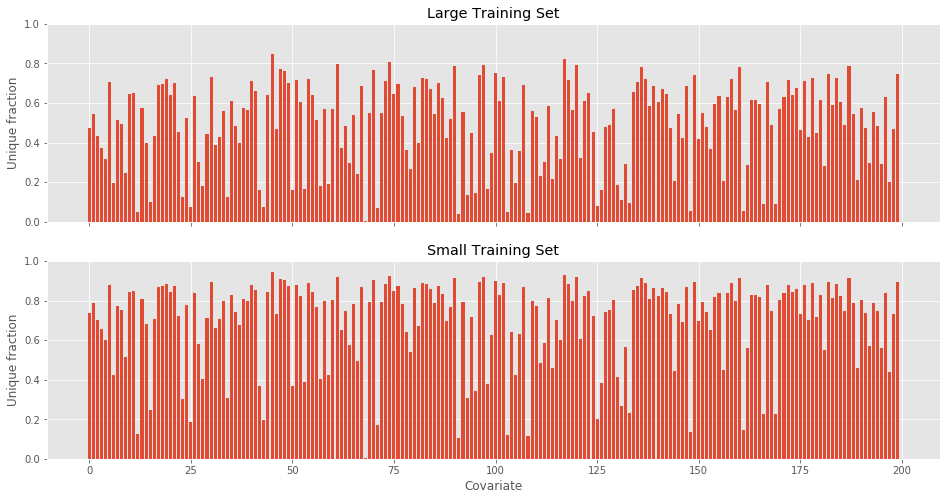

In [154]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

ax1.set_title("Large Training Set")
ax2.set_title("Small Training Set");

ax1.set_ylabel("Unique fraction")
ax2.set_ylabel("Unique fraction")
ax2.set_xlabel("Covariate")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

ax1.bar(x=range(0, 200), height=unique_large_train, width=0.75);
ax2.bar(x=range(0, 200), height=unique_small_train, width=0.75);

There is actually a surprising amount of _exact duplication_ column-wise, even when the features are floats. The likelihood for this in a theoretical, continuous, statistical distribution is zero, but in practice (due to data-entry rounding and floating point precisios) it is not a too shocking revelation.

Let's investigate this further by plotting the histogram of the least unique covariate besides the histogram of the most unique covariate.

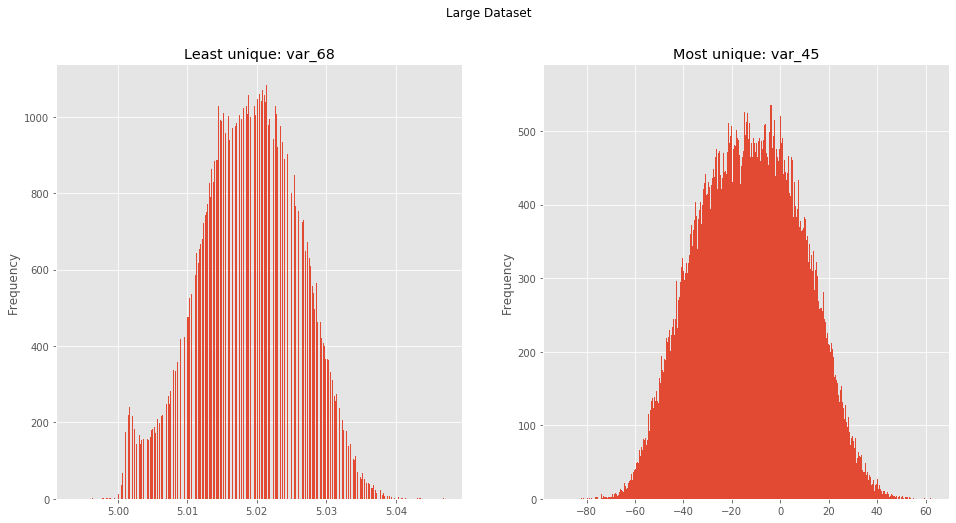

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Large Dataset")

least_unique = np.argmin(unique_large_train)
train_large.iloc[:, least_unique + 2].plot.hist(bins=1000, ax=ax1)
ax1.set_title(f"Least unique: var_{least_unique}")

most_unique = np.argmax(unique_large_train)
train_large.iloc[:, most_unique + 2].plot.hist(bins=1000, ax=ax2)
ax2.set_title(f"Most unique: var_{most_unique}");

We can see that the "non-uniqueness" of `var_68` is not necessarily a problem, the values seem to be somewhat discretized, but it still has a distinct distribution. The same conclusion should hold for the smaller dataset.

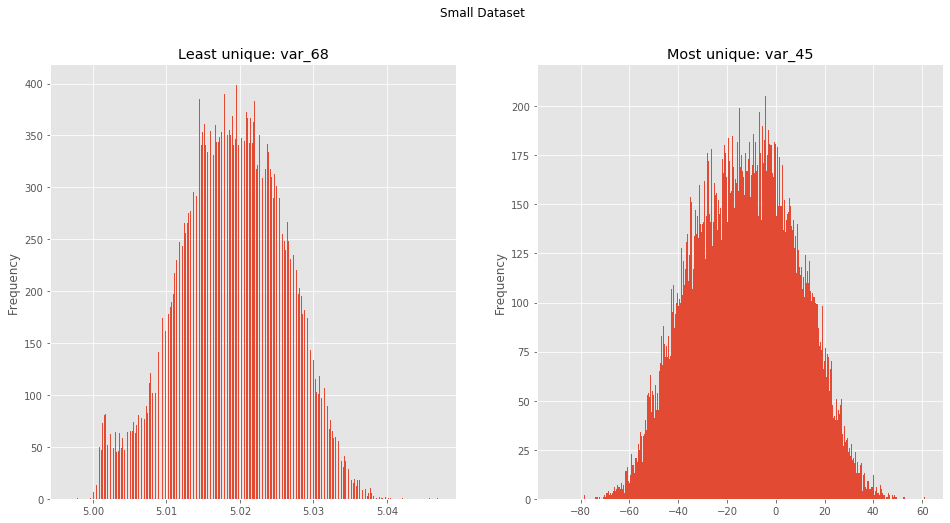

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Small Dataset")

least_unique = np.argmin(unique_small_train)
train_small.iloc[:, least_unique + 2].plot.hist(bins=1000, ax=ax1)
ax1.set_title(f"Least unique: var_{least_unique}")

most_unique = np.argmax(unique_small_train)
train_small.iloc[:, most_unique + 2].plot.hist(bins=1000, ax=ax2)
ax2.set_title(f"Most unique: var_{most_unique}");

Which it does...

We can also observe bell shapes in these histograms, which we will come back to.

## Class Balance

The proportion between `1` and `0` targets is of huge importance for how we tackle the upcoming prediction challenge, so we should take a look at the class (im)balance in the datasets.

In [191]:
for name, dataset in [("Small", train_small), ("Large", train_large)]:
    positives = (dataset.target == 1).sum()
    negatives = len(dataset) - positives
    
    positive_fraction = positives / (positives + negatives)
    negative_fraction = 1 - positive_fraction
    
    display(Markdown(
        f"* **{name} dataset**: "
        f"{100 * negative_fraction:.2f}% negatives, "
        f"{100 * positive_fraction:.2f}% positives"
    ))

* **Small dataset**: 90.03% negatives, 9.97% positives

* **Large dataset**: 89.95% negatives, 10.05% positives

For both datasets, we have a 90/10 split between negatives and positives, respectively. This can definitely be considered as an unbalanced class, which should be kept in mind during model building.

## Normality test

If our features are close to being normally distributed, a whole lot of additional statistical tests becomes available to us, such as the Student T test for instance (for distribution mean calculation tests).

We should therefore check if our features are close to normally distributed.

### Anderson-Darling Test

Let's start by applying the Anderson-Darling Test for normality on the entirety of the large dataset.

In [263]:
from scipy.stats import anderson

def anderson_normality(dataset):
    for feature in features:
        result = anderson(dataset[feature].to_numpy(), dist="norm")
        significance_levels = result.significance_level
        critical_values = result.critical_values
        statistic = result.statistic
        for critical_value, significance in zip(critical_values, significance_levels):
            is_normal = statistic < critical_value
            if is_normal:
                return True
    return False

anderson_normality(dataset=train_large)

False

Not a single feature is considered to be normally distributed even at a 15% significance level!
What about if we group the dataset by `target`?

In [265]:
print(anderson_normality(dataset=train_large[train_large.target == 0]))
print(anderson_normality(dataset=train_large[train_large.target == 1]))

False
False


Still not the case! We should therefore be careful with any normality assumptions going forwards.

## Describing Statistics

We will now take a look at some describing statistics, such as mean, standard deviation, etc..

What is really interesting for our prediction purposes is if these describing statistics differ significantly between observations with negative vs. positive labels.

Let's start by calculating the mean.

In [310]:
def normalized_delta(dataset):
    mean = dataset.groupby("target").mean()[features]
    delta_mean = (mean.iloc[0,:] - dataset.iloc[1,:]).abs()
    std = dataset.std()[features]
    normalized_delta_mean = (delta_mean / std)[features].astype(float)
    return normalized_delta_mean
    

In [318]:
normalized_delta_mean = normalized_delta(dataset=train_large)
sorted_deltas = normalized_delta_mean.sort_values()
largest_deltas = normalized_delta_mean[-6:-1]
smallest_deltas = normalized_delta_mean[0:5]

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(16, 10))
for axes, small, large in zip(ax, smallest_deltas.index, largest_deltas.index):
    train_large[train_large.target == 0][large].plot.density(ax=axes[0], color="red")
    train_large[train_large.target == 1][large].plot.density(ax=axes[0], color="green");
    
    train_large[train_large.target == 0][small].plot.density(ax=axes[0], color="red")
    train_large[train_large.target == 1][small].plot.density(ax=axes[0], color="green");

In [332]:
smallest_deltas.index

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4'], dtype='object')

In [315]:
normalized_delta_mean.sort_values()

var_153    0.004212
var_7      0.004536
var_37     0.008766
var_51     0.016145
var_143    0.021837
             ...   
var_15     2.114218
var_142    2.168638
var_89     2.401802
var_86     2.491571
var_179    3.047755
Length: 200, dtype: float64